In [ ]:
 ## RUN THIS CODE BLOCK BEFORE STARTING TUTORIAL ##
 # This is the same code from the previous section, nothing new here.
try:
  # We must install required packages if we are in Google Colab
  import google.colab
  %pip install roboticstoolbox-python>=1.0.2
except:
  # We are not in Google Colab
  # Apply custon style to notebook
  from IPython.core.display import HTML
  import pathlib
  styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
  styles = open(styles_path, "r").read()
  HTML(f"<style>{styles}</style>")

In [ ]:
## RUN THIS CODE BLOCK BEFORE STARTING TUTORIAL ##
#import necessary libraries for this specific notebook
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy import median
import pandas as pd

# 4.0 Numerical Inverse Kinematics

## Table of Contents

### 4.1 Introduction
### 4.2 Newton-Raphson (NR) Method
### 4.3 Gauss-Newton (GN) Method
### 4.4 Levenberg-Marquardt (LM) Method
### 4.5 Example

#4.1 Introduction
This section of our tutorial will introduce the topic of Inverse Kinematics. In the previous section of this tutorial, we covered the implementation of Position Kinematics and Forward Kinematics and discussed the computation of end-effector positions and orientations given the joint angles of a robotic arm. While forward kinematics allows us to determine the end-effector pose from the joint configurations, inverse kinematics serves the opposite purpose: it helps us calculate the joint angles required to achieve a desired end-effector pose.


To understand the purpose of inverse kinematics more clearly, let's look at a short example. Let's say you have a robotic arm, like the Kinova Gen 3 robotic arm, sitting in a table in front of you. The arm has several joints that represent a degree of freedom, which allows it to move in various directions. Now let's say you want to pick up a cup and place it in a different location. To accomplish this, you need to specify where you want the end of the arm (the gripper) to be in space. While you know the coordinates of the desired location, you don't know the exact angles of each joint that will position the gripper at that point. This is where inverse kinematics comes in. By inputting the desired position and orientation of the gripper (end-effector), inverse kinematics calculates the precise angles of each joint needed to achieve that pose.

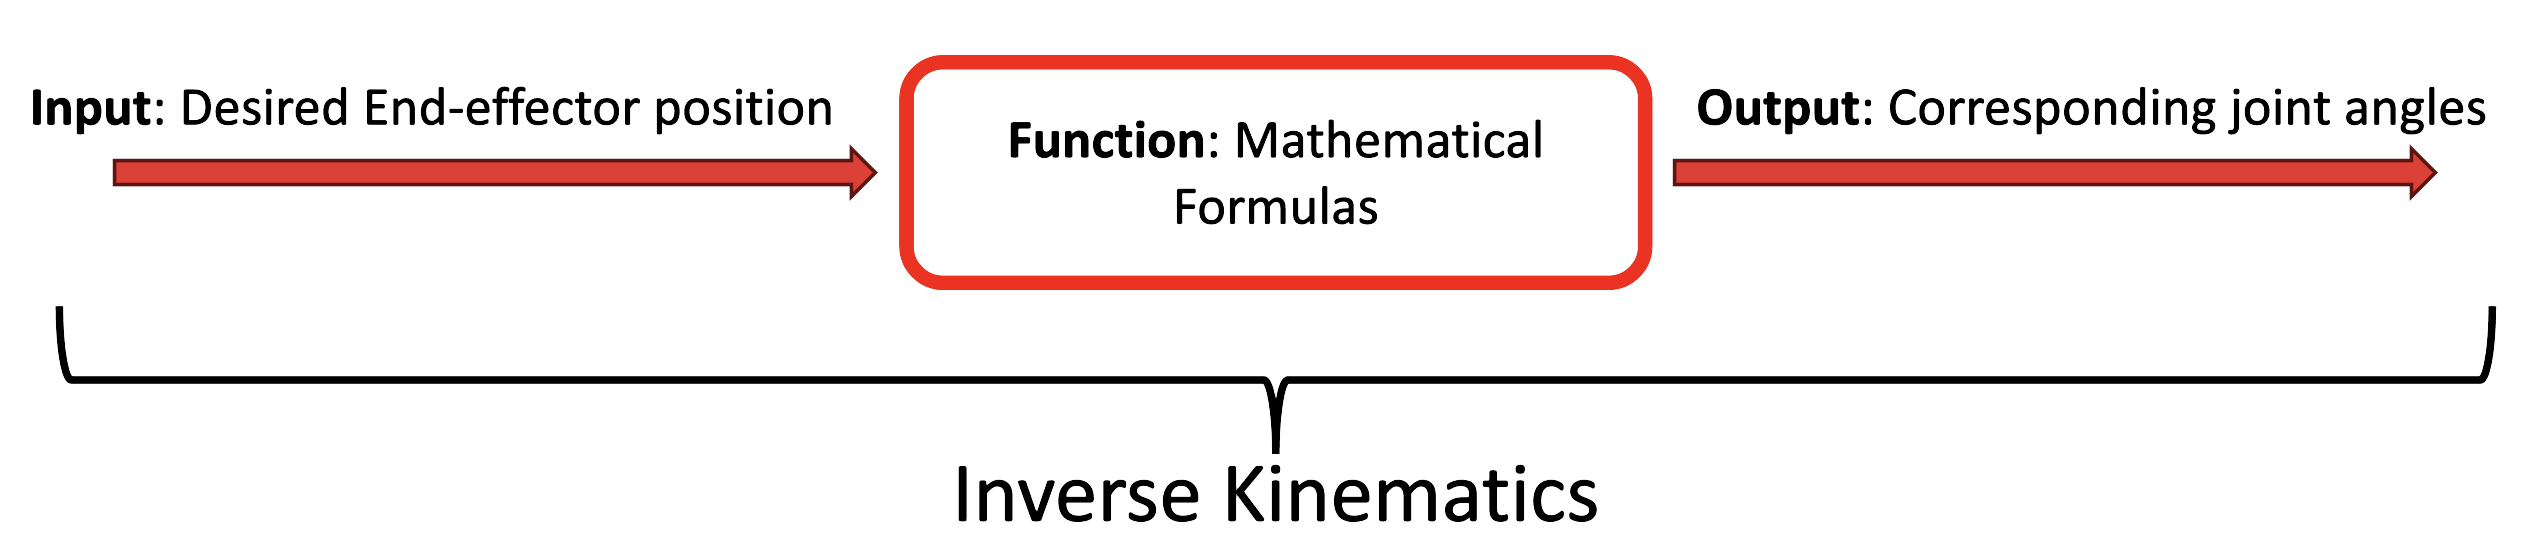

The error function quantifies the disparity between the desired end-effector pose and the actual pose achieved through the current joint angles. It will be used across the various inverse kinematics methods throughout this tutorial, such as Newton-Raphson, Gauss-Newton, and Levenberg-Marquard. This function guides the optimization process by iteratively minimizing the error. In this equation, 'E' represents the error as a scalar value, 'e' is the error vector, and 'We' represents the weighting matrix which was explained in Section 3 of this tutorial.

\begin{align*}
    E = \frac{1}{2} \bf{e}^{\top} \bf{W}_e \bf{e}
\end{align*}

### 4.2 Newton-Raphson (NR) Method

Now, building on our understanding of inverse kinematics, let's delve into a powerful method known as the Newton-Raphson method. The Newton-Raphson method approaches the inverse kinematic problem iteratively by refining initial estimates of joint angles until convergence is reached. At each iteration, it uses the Jacobian matrix, representing the rate of change of the end-effector pose with respect to changes in joint angles, along with an error vector that quantifies the differences between the current and desired pose. By iteratively updating the joint angles based on the error function, the method converges to a solution that minimizes the error, effectively aligning the robot arm with the target pose.

We begin by defining a transformation matrix for the desired end-effector pose. The transformation matrix defines the rotation and translation of the end effector for each axis (X, Y, Z).

In [ ]:
# defines end-effector pose and computes guess
T1 = np.array([[-1, 0, 0, 0.5],
                   [0, 0, 1, 0.5],
                   [0, 1, 0, 1],
                   [0, 0, 0, 1]])
q= q_initial_guess(T1)
# calls NR method to solve joint configuration
NR(q,T1,1000)

Newton Raphson Did not Converge


(False,
 array([-6.83937458,  0.14963581,  0.50704333,  0.72444607,  4.51135381,
         1.58408972, -0.79310206]),
 1000)

The Newton-Raphson method minimizes the error through an iterative process of the form,
\begin{align*}
    \bf{q}_{k+1} = \bf{q}_k + {^0\bf{J}(\bf{q}_k)}^{-1} \bf{e}_k.
\end{align*}

In this process, we update the joint angles (q) and adjust them based on how the error (e_k) is related to changes in joint angles as captured by the Jacobian matrix (J).

In [ ]:
#Initializing the function NR with three parameters:
# (q_initial): initial joint angles,
# (target_pose): desired end-effector pose,
# (max_iterations): Maximum number of iterations for NR
def NR(q_initial, target_pose, max_iterations):
    q = q_initial #
    error_NR = [] # makes a list to store quadratic error for NR
    limits = np.array([ #creates an array of joint angle limits
   # specifies lower and upper bounds for each joint in rad
   # keeps joint angles within acceptable ranges during iterations
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(128.9), np.deg2rad(128.9)],
    [-np.deg2rad(147.8), np.deg2rad(147.8)],
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(120.3), np.deg2rad(120.3)],
    [-np.deg2rad(360), np.deg2rad(360)]
    ])
    converged = False  # Flag to check if the method has converged
    # Set up the loop for a maximum number of iterations


Below, we initialize a loop to iterate through the necessary steps for the system to converge towards the desired end-effector pose. This loop is crucial in driving the iterative refinement process, where each iteration brings us closer to a solution that minimizes the error between the current and desired pose.

In [ ]:
for iteration in range(1, max_iterations + 1):

        # Enforce limitations on joints
        # clips any joint angle exceeding limits
        q = np.clip(q, limits[:, 0], limits[:, 1]) #clip method defines how during iteration if a joint reaches max then at next iteration itll stay the same

        # Set current joint angles to previous joint angles
        q_current = q # each iteration inputs a joint angle guess initally then continuousyly loops the output back in until the quadratic error is low enough.

        # Calculate quadratic error
        EN = QuadraticError(target_pose, fk(q_current)) # calculating Quadratic Error convergence criterion. The

        # Calculate error for Newton-Raphson equation
        ek = Err(target_pose, fk(q_current))

        # computes updated step 'x' by multiplying pseudo-inverse Jacobian
        # and error vector. Inidcates needed adjustement to joint angles.
        x = np.dot(np.linalg.pinv(J(q_current)), ek)
        x = np.reshape(x,(1,7))
        # Newton-Raphson equation answer is a column of angles
        q = np.add(q,x)


        # Fill the error array with the latest value of E
        error_NR.append(EN)
        q = np.squeeze(q)

        # Check for convergence
        if EN < 1e-5:
            converged = True
            print(f'Newton-Raphson method converged in {iteration} iterations.')
            break

In [ ]:
max_iterations = 5
# Set up the loop for a maximum number of iterations
for iteration in range(1, max_iterations + 1):

        # Enforce limitations on joints
        # clips any joint angle exceeding limits
        q = np.clip(q, limits[:, 0], limits[:, 1]) #clip method defines how during iteration if a joint reaches max then at next iteration itll stay the same

        # Set current joint angles to previous joint angles
        q_current = q # each iteration inputs a joint angle guess initally then continuousyly loops the output back in until the quadratic error is low enough.

        # Calculate quadratic error
        EN = QuadraticError(target_pose, fk(q_current)) # calculating Quadratic Error convergence criterion. The

        # Calculate error for Newton-Raphson equation
        ek = Err(target_pose, fk(q_current))

        # computes updated step 'x' by multiplying pseudo-inverse Jacobian
        # and error vector. Inidcates needed adjustement to joint angles.
        x = np.dot(np.linalg.pinv(J(q_current)), ek)
        x = np.reshape(x,(1,7))
        # Newton-Raphson equation answer is a column of angles
        q = np.add(q,x)


        # Fill the error array with the latest value of E
        error_NR.append(EN)
        q = np.squeeze(q)

        # Check for convergence
        if EN < 1e-5:
            converged = True
            print(f'Newton-Raphson method converged in {iteration} iterations.')
            break


NOTE: It is important to note that the inverse of the Jacobian incorporated in the calculations for inverse kinematics requires a square invertible matrix. However, as discussed in Section 2 of this tutorial, the calculation for the Jacobian of a 7 DOF robotic arm will not produce a square matrix. Consequently, the **Moore-Penrose pseudo inverse** is applied to allow for the computation of joint velocities from desired end-effector velocities. This pseudo inverse method is necessary for handling non-square or non-singular matrices, ensuring accurate motion planning and control in the system.

Lastly, once the system has converged, we can output the joint angles as well as the converged position and orientation of the end-effector. This is found through forward kinematics as described in the previous section of this tutorial.

In [ ]:
if converged:
        error_NR = np.concatenate(error_NR)
        np.savetxt('error_Nr.txt', error_NR)
        print(f'Initial Joint Angle Guess: {np.rad2deg(q_initial)}.')
        print(f'Final Quadratic Error for NR: {EN}.')
        print(f'Iteration: {iteration}.')
        print('Desired Position and Orientation:')
        print(target_pose)
        print('Converged Joint Angles using NR:')
        print(np.rad2deg(q))
        print('Converged Position and Orientation using NR (degrees):')
        B = np.round(fk(q), decimals=4)
        print(B)
        iteration = np.arange(1, len(error_NR) + 1)
        # plt.plot(iteration, error_NR, label='NR')
        # plt.xlabel('Iterations')
        # plt.ylabel('Error')
        # plt.title('Convergence of Newton-Raphson Method')
        # plt.legend()
        # plt.show()
else:
        print('Newton Raphson Did not Converge')


NameError: name 'converged' is not defined

###4.3 Gauss-Newton (GN) Method


Next, we delve into the Gauss-Newton method, another powerful technique in the realm of robotic manipulation. Unlike the Newton-Raphson method, which approaches inverse kinematics with a straightforward iterative approach, the Gauss-Newton method takes a different route. Instead of directly solving for the joint angles, it treats the problem as an optimization task. By minimizing the error between the current and desired end-effector pose, the Gauss-Newton method iteratively adjusts the joint angles to converge towards a solution.

With the Gauss-Newton method, we incorporate the effect of weightings. As described in Section 3, weightings refer to assigning relative importance or influence to different components of the error vector. By assigning weights, you can prioritize certain dimensions or observations over others during the optimization process.

In [ ]:
 #initialize array 'we' containing weights for
 #each element of the error vector
 we = np.array([1, 1, 1, 1, 1, 1]) # all elements assigned weight of 1
 We = np.diag(we)

In [ ]:
#Initializing the function NR with three parameters:
def GN(q_initial, target_pose, max_iterations):
    # Initialize joint angles
    # same as NR Method
    q = q_initial
    q = np.delete(q, 2)
    error_GN = []
    we = np.array([1, 1, 1, 1, 1, 1])
    We = np.diag(we)
    limits = np.array([
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(128.9), np.deg2rad(128.9)],
    [-np.deg2rad(147.8), np.deg2rad(147.8)],
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(120.3), np.deg2rad(120.3)],
    [-np.deg2rad(360), np.deg2rad(360)]
    ])


Similar to the Newton-Raphson method, the Gauss-Newton function (GN) implements a funtion to update the joint angles of a robotic arm (q) based on how the end-effector's pose changes with those angles (Jacobian matrix), the importance of different error components (weighting matrix), and the direction of the steepest ascent of the error (gradient).


\begin{align*}
    \bf{q}_{k+1} &= \bf{q}_k +
    \left(
    {\bf{J}(\bf{q}_k)}^\top
    \bf{W}_e \
    {\bf{J}(\bf{q}_k)}
    \right)^{-1}
    \bf{g}_k \\
  \end{align*}

The gradient factor (g_k) in the Gauss-Newton method guides the adjustment of joint angles in the Kinova arm to minimize the difference between the desired and actual end-effector pose. It indicates the direction in which the joint angles should be adjusted to reduce the error between the current and desired positions and orientations of the arm. The gradient factor helps steer the optimization process towards convergence to the desired pose.

\begin{align*}
    \bf{g}_k &=
    {\bf{J}(\bf{q}_k)}^\top
    \bf{W}_e
    \bf{e}_k
\end{align*}


In [ ]:
    # ^^ Implement loop for iterations as in NR Method
    # Gauss-Newton equation answer is a column of angles
        J=J6(q_current) # calculates Jacobian at current joint angles
        JT=np.transpose(J6(q_current)) # transpose Jacobian

        gk = np.linalg.multi_dot([JT,We,ek]) # compute gradient
        x = np.linalg.multi_dot([JT,We,J]) # Compute Hessian Matrix

        # calculates update step 'y' using Moore-Penrose pseudo-inverse
        y = np.dot(np.linalg.pinv(x),gk)
        y = np.reshape(y,(1,6))
        q = np.add(q,y) # update joint angles

The algorithm iterates continuously until convergence is achieved, which is determined by a threshold for the quadratic error. When the quadratic error falls below a very small value, indicating that further optimization will not significantly reduce the error, the algorithm ends.

In [ ]:
      # check for convergence
      if EG < 1e-28:
            print(f'Guass-Newton method converged in {iteration} iterations.')
            break
        elif np.linalg.det(J) == 0:
            print('Guass-Newton Method is infeasible')
            break

### 4.4 Levenberg-Marquardt (LM)

Expanding on our grasp of inverse kinematics, let's delve into a method called the Levenberg-Marquardt method. Similar to the Newton-Raphson approach, it tackles inverse kinematics problems through iterative refinement of joint angle estimates until convergence is achieved. However, unlike the other methods, the method includes a damping parameter. This parameter dynamically adjusts step sizes during optimization, which ensures stable convergence and improves solvaility. By balancing between gradient descent and Gauss-Newton techniques, the Levenberg-Marquardt method improves optimization, ultimately reaching a solution that reduces error and accurately aligns the arm with the desired target pose.


\begin{align*}
    \bf{q}_{k+1}
    &=
    \bf{q}_k +
    \left(
    \bf{A}_k
    \right)^{-1}
    \bf{g}_k\\
    %
\end{align*}

\begin{align*}
    \bf{A}_k
    &=
    {\bf{J}(\bf{q}_k)}^\top
    \bf{W}_e \
    {\bf{J}(\bf{q}_k)}
    +
    \bf{W}_n
\end{align*}

By modifying the previous formula for the Gauss-Newton method and incorporating a damping matrix (Wn), the system stabilizes the optimization process and ensures convergence. It's important to note that the chosen values of Wn define the performance of this method.

\begin{align*}
\bf{W}_n = \text{diag}(\bf{w_n})(\bf{w_n} \in \mathbb{R}^n_{>0})
\end{align*}

In this formula, 'Wn' respresents a square damping matrix used to adjust the step size during optimization. The diagonal of the matrix is made up of the elements in the vector 'wn' which are specified to be positive real numbers.

#### Wampler's Method

One of the methods for the Levenberg-Marqauardt (LM) algorithm is the Wampler method. It involves treating the problem as an optimization task, aiming to minimize the squared error between the desired end-effector position and the actual position achieved by the robot arm. This method typically uses numerical optimization techniques such as gradient descent or Newton's method to adjust the joint angles until the error is minimized. Wampler's method is typically known for its flexibility and being able to handle various types of kinematic problems. It allows for precise control over the optimization process and can be easily manipulated to specific systems.

In [ ]:
# Initialize function WM with four parameters:
# (lm): damping factor
def WM(q_initial, target_pose, max_iterations, lm):
    # Initialize joint angles
    q = q_initial
    q = np.delete(q, 2)
    error_WM = []
    we = np.array([1, 1, 1, 1, 1, 1])
    We = np.diag(we) # weighting matrix
    wn = np.array([lm, lm, lm, lm, lm, lm]) # damping vector
    Wn = np.diag(wn) # damping matirx of diagonal wn values


In [ ]:
# Set up the loop for a maximum number of iterations
    for iteration in range(1, max_iterations + 1):

        # Enforce limitations on joints
        q[0] = np.clip(q[0], -np.deg2rad(360), np.deg2rad(360))
        q[1] = np.clip(q[1], -np.deg2rad(128.9), np.deg2rad(128.9))
        q[2] = np.clip(q[2], -np.deg2rad(147.8), np.deg2rad(147.8))
        q[3] = np.clip(q[3], -np.deg2rad(360), np.deg2rad(360))
        q[4] = np.clip(q[4], -np.deg2rad(120.3), np.deg2rad(120.3))
        q[5] = np.clip(q[5], -np.deg2rad(360), np.deg2rad(360))

        # Set current joint angles to previous joint angles
        q_current = np.insert(q, 2, 0)

        # Calculate quadratic error
        EW = QuadraticError(target_pose, fk(q_current))

        # Calculate error
        ek = Err(target_pose, fk(q_current))

        # Gauss-Newton equation answer is a column of angles
        J = J6(q_current)
        JT = np.transpose(J)
        gk = np.linalg.multi_dot([JT,We,ek])
        x = np.linalg.multi_dot([JT,We,J])
        Ak = np.add(x,Wn) ##################### Add damping diagonal matrix
        y = np.dot(np.linalg.inv(Ak),gk)
        y = np.reshape(y,(1,6))
        q = np.add(q,y)

#### Chan's Method

Chan's method involves specific modifications or enhancements to the original Levenberg-Marquardt algorithm to improve its performance or address specific challenges in inverse kinematics. Commonly for Chan's method, a geometric approach is used to formulate relationships between joint angles and end-effector positions.



In Chan's method, the damping matrix is defined below,


\begin{align*}
    \bf{W}_n
    &=
    \lambda E_k \bf{1}_n
\end{align*}


It uses a damping matrix (Wn) to manage the step size and convergence behaviour of the inverse kinematics problem. In this calculation, Chan's method defines the damping matrix (Wn) by multiplying the damping parameter (lm) with the error vector (Ek) and the weighting matrix of all one's (We).

In [ ]:
Wn = lm * EC * We # Chans method for damping matrix

In [ ]:
def CM(q_initial, target_pose, max_iterations, lm):
    # Initialize joint angles
    q = np.deg2rad(q_initial)
    q = np.delete(q, 2)
    error_CM = []
    we = np.array([1, 1, 1, 1, 1, 1]) # weighting vector of 1s
    We = np.diag(we) # weighting matrix of 1s


In [ ]:
 # Gauss-Newton equation answer is a column of angles
        Wn = lm * EC * We # damping matrix
        J = J6(q_current)
        JT = np.transpose(J)
        gk = np.linalg.multi_dot([JT,We,ek])
        x = np.linalg.multi_dot([JT,We,J])
        Ak = np.add(x,Wn)#  Add damping diagonal matrix
        y = np.dot(np.linalg.inv(Ak),gk)
        y = np.reshape(y,(1,6))
        q = np.add(q,y)

#### Sugihara's Method

Sugihara's method is an extension or refinement of the Levenberg-Marquardt algorithm that is altered to improve the performance of robotic systems. Adjustments to the damping strategy, error weighting, or optimization process are normally considered in Sugihara's method to improve the convergence behaviour, stability, or efficiency when solving the inverse kinematics for the arm.

In Sugihara's method, the damping matrix is defined below,



\begin{align*}
    \bf{W}_n
    &=
    E_k \bf{W}_e + \text{diag}(\hat{\bf{w}}_n)
\end{align*}

In this equation, The error vector (Ek) and weighting matrix (We) are multiplied and added to a diagonal matrix of the damping vector (wn).

In [ ]:
# Initialize function SM with four parameters:
def SM(q_initial, target_pose, max_iterations, lm):
    # Initialize joint angles
    q = np.deg2rad(q_initial)
    q = np.array(q)
    error_SM = []
    wn = np.array([lm, lm, lm, lm, lm, lm, lm]) #damping vector
    We = np.eye(6) # weighting matrix


In [ ]:
        # Calculate quadratic error
        ES = QuadraticError(target_pose, fk(q_current))

        # Calculate error
        ek = Err(target_pose, fk(q_current))


        Wn = ES*np.eye(7) + np.diag(wn) #damping matrix
        j = J(q_current)
        JT = np.transpose(j)
        gk = np.linalg.multi_dot([JT,We,ek]) # compute gradient
        x = np.linalg.multi_dot([JT,We,j])
        Ak = np.add(x,Wn)
        y = np.dot(np.linalg.pinv(Ak),gk)
        y = np.reshape(y,(1,7))
        q = np.add(q,y)

The error array is filled and continuously checked for convergence until the method has converged.

In [ ]:
     # Fill the error array with the latest value of E
        error_SM.append(ES)
        q = np.squeeze(q)

        if ES < 1e-5:
            converged = True
            print(f'Sugiharas Method converged in {iteration} iterations.')
            break


### 4.5 Example

<font color='red'>** It is critical that before running this code you run the Appendix cell below**

To better understand the differences between the three methods, (Newton-Raphson, Gauss-Newton, and Levenberg-Marquadt) try the following example to compare the results of these methods. In the following code, each method for Inverse Kinematics is run through 10 trials. At the end, the program outputs a graph comparing the number of times each method converged, and at what frequency.

To get a better representation of each method, complete the following change:

1. Change the "trial" value from 10 to 30.
2. Run the code and compare results for each method

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy import median
import pandas as pd

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Avoid wrapping to the next line
pd.set_option('display.max_rows', None)     # Show all rows

def run_experiment(method, method_name, trials=10, **kwargs): ##  trials value can changed
    iteration = []
    non_converge_count = 0

    for _ in range(trials):
        angles = angle_guess()
        target = pose_guess()
        converged, q_final, iterations = method(angles, target, 100, **kwargs)
        if converged:
            iteration_count = len(iterations)
            iteration.append(iteration_count)

        else:
            non_converge_count += 1

    avg_iterations = np.mean(iteration) if iteration else 0
    median_iterations = median(iteration) if iteration else 0
    non_converge_percentage = (non_converge_count / trials) * 100

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(iteration, bins=range(1, 201), alpha=0.7, label=f'{method_name}')
    plt.title(f'Convergence Iterations Distribution for {method_name}')
    plt.xlabel('Iterations to Converge')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'{method_name}_convergence_distribution.png')

    return {
        'Method': method_name,
        'Average Iterations': avg_iterations,
        'Median Iterations': median_iterations,
        'Non-convergence Count': non_converge_count,
        'Non-convergence Percentage': non_converge_percentage
    }

# Assuming you've defined or imported your methods correctly, here's how you could structure your main experiment loop:
results = []
methods = [
    {'method': NR, 'name': 'NR', 'kwargs': {}},
    {'method': GN, 'name': 'GN', 'kwargs': {}},
    {'method': WM, 'name': 'WM_0.0001', 'kwargs': {'lm': 0.0001}}, ## value can changed
    {'method': WM, 'name': 'WM_1e-6', 'kwargs': {'lm': 1e-6}}, ## value can changed
    {'method': CM, 'name': 'CM_1', 'kwargs': {'lm': 1}}, ## value can changed
    {'method': CM, 'name': 'CM_0.1', 'kwargs': {'lm': 0.1}}, ## value can changed
    {'method': SM, 'name': 'SM_0.028773368', 'kwargs': {'lm': 0.028773368}},
    {'method': SM, 'name': 'SM_0.000287734', 'kwargs': {'lm': 0.000287734}},
]

for method_info in methods:
    result = run_experiment(method_info['method'], method_info['name'], **method_info['kwargs'])
    results.append(result)

# Assuming results is a list of dictionaries as returned by run_experiment, you could then use pandas or another library to format and print this as a table

results_df = pd.DataFrame(results)
print(results_df)

## Appendix

In [ ]:
def alpha(M):

    def I(M):
        return np.array([[M[2,1] - M[1,2]],
                        [M[0,2] - M[2,0]],
                        [M[1,0] - M[0,1]]])

    A = np.linalg.norm(I(M)) #if norm is 0 then M is a digonal
    if A < 1e-6: #instead of considering a diagonal with values of 0, we consider a very small value
       if M[0, 0] == 1 and M[1, 1] == 1 and M[2, 2] == 1:
        alpha = np.array([[0], [0], [0]])
       else:
          alpha = (np.pi / 2) * np.array([[M[0, 0] + 1],
                                        [M[1, 1] + 1],
                                        [M[2, 2] + 1]])
    else: # not diagonal
        B = M[0, 0] + M[1, 1] + M[2, 2] - 1
        alpha = np.dot(np.divide(np.arctan2(A, B),A), I(M))

    return alpha

def angle_guess():
    # Extract x and y from Tt
    # Define the bounds
    max_val = 360
    min_val = -360
    max_q2 = 128.9
    min_q2 = -128.9
    max_q4 = 147.8
    min_q4 = -147.8
    max_q6 = 120.3
    min_q6 = -120.3

    # Initial guesses for joint angles
    # q1 = q1_initialguess(x, y)
    # q2 = q2_initialguess(x, y)
    q1 = np.random.uniform(min_val, max_val)
    q2 = np.random.uniform(min_q2, max_q2)
    q3 = np.random.uniform(min_val, max_val)
    q4 = np.random.uniform(min_q4, max_q4)
    q5 = np.random.uniform(min_val, max_val)
    q6 = np.random.uniform(min_q6, max_q6)
    q7 = np.random.uniform(min_val, max_val)

    # Initialize joint angles
    #q_initial_guess = np.deg2rad([q1, q2, q3, q4, q5, q6, q7])
    return np.deg2rad([q1, q2, q3, q4, q5, q6, q7])

def round_to(number, precision):
    return np.where(np.abs(number) < precision, 0, number)
def fk(q_values):
    q1 = q_values[0];
    q2 = q_values[1];
    q3 = q_values[2];
    q4 = q_values[3];
    q5 = q_values[4];
    q6 = q_values[5];
    q7 = q_values[6];

    E1 = T(0, 0, 0.15643)
    E2 = Rx(np.pi)
    E3 = Rz(q1)
    E4 = T(0, 0, -0.12838)
    E5 = T(0, 0.00538, 0)
    E6 = Rx(np.pi/2)
    E7 = Rz(q2)
    E8 = T(0, 0, -0.00638)
    E9 = T(0, -0.21038, 0)
    E10 = Rx(-np.pi/2)
    E11 = Rz(q3)
    E12 = T(0, 0, -0.21038)
    E13 = T(0, 0.00638, 0)
    E14 = Rx(np.pi/2)
    E15 = Rz(q4)
    E16 = T(0, 0, -0.00638)
    E17 = T(0, -0.20843, 0)
    E18 = Rx(-np.pi/2)
    E19 = Rz(q5)
    E20 = T(0, 0, -0.10593)
    E21 = Rx(np.pi/2)
    E22 = Rz(q6)
    E23 = T(0, -0.10593, 0)
    E24 = Rx(-np.pi/2)
    E25 = Rz(q7)
    E26 = T(0, 0, -0.06153)
    E27 = Rx(np.pi)
    E28 = T(0.0089253606274724, 0.004642492, 0.120162814)


       # Intermediate variables
    terms = [E1, E2, E3, E4, E5, E6, E7, E8, E9, E10,
         E11, E12, E13, E14, E15, E16, E17, E18, E19,
         E20, E21, E22, E23, E24, E25, E26, E27, E28]

    HTM = np.linalg.multi_dot(terms)

    return round_to(HTM,1e-13)

def is_diagonal(matrix):
    # Check if the matrix is square
    if len(matrix) != len(matrix[0]):
        return False

    # Iterate through rows and columns
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            # If an off-diagonal element is not zero, return False
            if i != j and matrix[i][j] !=  0:
                return False

    # If no off-diagonal elements are non-zero, return True
    return True

def J(q_values):
    q1, q2, q3, q4, q5, q6, q7 = q_values

    E1 = T(0, 0, 0.15643)
    E2 = Rx(np.pi)
    E3 = Rz(q1)
    E4 = T(0, 0, -0.12838)
    E5 = T(0, 0.00538, 0)
    E6 = Rx(np.pi/2)
    E7 = Rz(q2)
    E8 = T(0, 0, -0.00638)
    E9 = T(0, -0.21038, 0)
    E10 = Rx(-np.pi/2)
    E11 = Rz(q3)
    E12 = T(0, 0, -0.21038)
    E13 = T(0, 0.00638, 0)
    E14 = Rx(np.pi/2)
    E15 = Rz(q4)
    E16 = T(0, 0, -0.00638)
    E17 = T(0, -0.20843, 0)
    E18 = Rx(-np.pi/2)
    E19 = Rz(q5)
    E20 = T(0, 0, -0.10593)
    E21 = Rx(np.pi/2)
    E22 = Rz(q6)
    E23 = T(0, -0.10593, 0)
    E24 = Rx(-np.pi/2)
    E25 = Rz(q7)
    E26 = T(0, 0, -0.06153)
    E27 = Rx(np.pi)



    # ... Define other transformation matrices (E4 to E27) similarly ...
    A = [None] * 9
    A[1] = np.linalg.multi_dot([E1, E2, E3])
    A[2] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7])
    A[3] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11])
    A[4] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15])
    A[5] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19])
    A[6] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19, E20, E21, E22])
    A[7] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19, E20, E21, E22, E23, E24, E25])
    A[8] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19, E20, E21, E22, E23, E24, E25, E26, E27])


    t0 = np.array([0, 0, 0])
    z0 = np.array([0, 0, 1])

    # Initialize lists to store t and z
    t = [np.empty((3, 0))] * 9
    z = [np.empty((3, 0))] * 9

# Loop through A to extract the last column for t and the third column for z
    for i in range(1, 9):
     t[i] = A[i][:-1, -1]
     z[i] = A[i][:-1, 2]


# Initialize a list to store the cross products
    cp = [None] * 9

# Calculate the cross products for each pair of vectors (z{i}, (t{end} - t{i}))
    cp[1] = np.cross(z0, (t[-1] - t0))
    cp[2] = np.cross(z[1], (t[-1] - t[1]))
    cp[3] = np.cross(z[2], (t[-1] - t[2]))
    cp[4] = np.cross(z[3], (t[-1] - t[3]))
    cp[5] = np.cross(z[4], (t[-1] - t[4]))
    cp[6] = np.cross(z[5], (t[-1] - t[5]))
    cp[7] = np.cross(z[6], (t[-1] - t[6]))
    cp[8] = np.cross(z[7], (t[-1] - t[7]))

# Reshape the elements of cp
    for i in range(1, 9):
     cp[i] = cp[i].reshape(3, 1)

# Reshape the elements of z
    for i in range(1,9):
     z[i] = z[i].reshape(3, 1)

# Ensure all arrays have the same size along axis 1
    z0 = z0.reshape(3, 1)

# Vertically stack cp[1] and z0
    v = [None] * 9
    v[1] = np.vstack([cp[1], z0])
    v[2] = np.vstack([cp[2], z[1]])
    v[3] = np.vstack([cp[3], z[2]])
    v[4] = np.vstack([cp[4], z[3]])
    v[5] = np.vstack([cp[5], z[4]])
    v[6] = np.vstack([cp[6], z[5]])
    v[7] = np.vstack([cp[7], z[6]])
    v[8] = np.vstack([cp[8], z[7]])

# Horizontally stack with the next vertical stack
    #J = v[1:]
    J = np.hstack([v[1],v[2],v[3],v[4],v[5],v[6],v[7],v[8]])
    J = np.delete(J, 0, axis=1)

    return J
def J6(q_values):
    q1 = q_values[0];
    q2 = q_values[1];
    q3 = q_values[2];
    q4 = q_values[3];
    q5 = q_values[4];
    q6 = q_values[5];
    q7 = q_values[6];

    E1 = T(0, 0, 0.15643)
    E2 = Rx(np.pi)
    E3 = Rz(q1)
    E4 = T(0, 0, -0.12838)
    E5 = T(0, 0.00538, 0)
    E6 = Rx(np.pi/2)
    E7 = Rz(q2)
    E8 = T(0, 0, -0.00638)
    E9 = T(0, -0.21038, 0)
    E10 = Rx(-np.pi/2)
    E11 = Rz(q3)
    E12 = T(0, 0, -0.21038)
    E13 = T(0, 0.00638, 0)
    E14 = Rx(np.pi/2)
    E15 = Rz(q4)
    E16 = T(0, 0, -0.00638)
    E17 = T(0, -0.20843, 0)
    E18 = Rx(-np.pi/2)
    E19 = Rz(q5)
    E20 = T(0, 0, -0.10593)
    E21 = Rx(np.pi/2)
    E22 = Rz(q6)
    E23 = T(0, -0.10593, 0)
    E24 = Rx(-np.pi/2)
    E25 = Rz(q7)
    E26 = T(0, 0, -0.06153)
    E27 = Rx(np.pi)



    # ... Define other transformation matrices (E4 to E27) similarly ...
    A = [None] * 9
    A[1] = np.linalg.multi_dot([E1, E2, E3])
    A[2] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7])
    #A[3] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11])
    A[3] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15])
    A[4] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19])
    A[5] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19, E20, E21, E22])
    A[6] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19, E20, E21, E22, E23, E24, E25])
    A[7] = np.linalg.multi_dot([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19, E20, E21, E22, E23, E24, E25, E26, E27])


    t0 = np.array([0, 0, 0])
    z0 = np.array([0, 0, 1])

    # Initialize lists to store t and z
    t = [np.empty((3, 0))] * 8
    z = [np.empty((3, 0))] * 8

# Loop through A to extract the last column for t and the third column for z
    for i in range(1, 8):
     t[i] = A[i][:-1, -1]
     z[i] = A[i][:-1, 2]


# Initialize a list to store the cross products
    cp = [None] * 8

# Calculate the cross products for each pair of vectors (z{i}, (t{end} - t{i}))
    cp[1] = np.cross(z0, (t[-1] - t0))
    cp[2] = np.cross(z[1], (t[-1] - t[1]))
    cp[3] = np.cross(z[2], (t[-1] - t[2]))
    cp[4] = np.cross(z[3], (t[-1] - t[3]))
    cp[5] = np.cross(z[4], (t[-1] - t[4]))
    cp[6] = np.cross(z[5], (t[-1] - t[5]))
    cp[7] = np.cross(z[6], (t[-1] - t[6]))

# Reshape the elements of cp
    for i in range(1, 8):
     cp[i] = cp[i].reshape(3, 1)

# Reshape the elements of z
    for i in range(1,8):
     z[i] = z[i].reshape(3, 1)

# Ensure all arrays have the same size along axis 1
    z0 = z0.reshape(3, 1)

# Vertically stack cp[1] and z0
    v = [None] * 8
    v[1] = np.vstack([cp[1], z0])
    v[2] = np.vstack([cp[2], z[1]])
    v[3] = np.vstack([cp[3], z[2]])
    v[4] = np.vstack([cp[4], z[3]])
    v[5] = np.vstack([cp[5], z[4]])
    v[6] = np.vstack([cp[6], z[5]])
    v[7] = np.vstack([cp[7], z[6]])

# Horizontally stack with the next vertical stack
    #J = v[1:]
    J = np.hstack([v[1],v[2],v[3],v[4],v[5],v[6],v[7]])
    J = np.delete(J, 0, axis=1)

    return J


def pose_guess():
    # Put all variables into a list
    while True:
        # Generate random points within a cube until one falls inside the semi-sphere
        radius = 0.73512
        max_z = 1.01793
        x = random.uniform(-radius, radius)
        y = random.uniform(-radius, radius)
        z = random.uniform(0, max_z)  # Limiting z to the upper hemisphere

        if (np.abs(x)>=0.15) and (np.abs(y)>=0.15) and  (x**2 + y**2 + z**2 <= radius**2):  # Check if the point is inside the semi-sphere

            A = np.array([[ 0,  1,  0 ],
                          [ 1,  0,  0 ],
                          [ 0,  0, -1 ]])

            B = np.array([[-1,  0,  0 ],
                          [ 0,  1,  0 ],
                          [ 0,  0, -1 ]])

            C = np.array([[-1,  0,  0 ],
                          [ 0,  0,  1 ],
                          [ 0,  1,  0 ]])

            D = np.array([[ 0,  0,  1 ],
                          [ 1,  0,  0 ],
                          [ 0,  1,  0 ]])

            E = np.array([[ 1,  0,  0 ],
                          [ 0,  0, -1 ],
                          [ 0,  1,  0 ]])

            F = np.array([[ 1,  0,  0 ],
                          [ 0, -1,  0 ],
                          [ 0,  0, -1 ]])

            G = np.array([[ 0,  0, -1 ],
                          [-1,  0,  0 ],
                          [ 0,  1,  0 ]])

            H = np.array([[ 0, -1,  0 ],
                          [-1,  0,  0 ],
                          [ 0,  0, -1 ]])

            variables = [A, B, C, D, E, F, G, H]
            rand_orien = random.choice(variables)
            pose_guess = np.eye(4)
            pose_guess[:3, :3] = rand_orien
            pose_guess[0,3] = x
            pose_guess[1,3] = y
            pose_guess[2,3] = z

            break

    return pose_guess


def q_initial_guess(Tt):
  # Extract x and y from Tt
  x = Tt[0, 3]
  y = Tt[1, 3]
  z = Tt[2, 3]
  # Define the bounds
  max_val = 360
  min_val = -360
  max_q2 = 128.9
  min_q2 = -128.9
  max_q4 = 147.8
  min_q4 = -147.8
  max_q6 = 120.3
  min_q6 = -120.3

  # Initial guesses for joint angles
  # q1 = q1_initialguess(x, y)
  # q2 = q2_initialguess(x, y)

  if z < 0.25 and x > 0:
          q2 = np.random.uniform(90, max_q2)
  elif z < 0.25 and x < 0:
          q2 = np.random.uniform(min_q2, -90)
  else:
          q2 = np.random.uniform(min_q2, max_q2)

  q1  = np.arctan2(x, y) - np.deg2rad(90)
  q3 = np.random.uniform(min_val, max_val)
  q4 = np.random.uniform(min_q4, max_q4)
  q5 = np.random.uniform(min_val, max_val)
  q6 = np.random.uniform(min_q6, max_q6)
  q7 = np.random.uniform(min_val, max_val)

  # Initialize joint angles
  #q_initial_guess = np.deg2rad([q1, q2, q3, q4, q5, q6, q7])
  return np.deg2rad([q1, q2, q3, q4, q5, q6, q7])



def q1_initialguess(Tt):
     # Extract x and y from Tt
    x = Tt[0, 3]
    y = Tt[1, 3]
    if x == 0 and y == 0:
        q1 = 0
    elif x == 0 and y < 0:
        q1 = 90
    elif x < 0 and y == 0:
        q1 = 180
    elif x == 0 and y > 0:
        q1 = 270
    elif x > 0 and y == 0:
        q1 = 360
    elif x > 0 and y < 0:
        q1 = np.random.rand() * 90
    elif x < 0 and y < 0:
        q1 = (np.random.rand() * 90) + 90
    elif x < 0 and y > 0:
        q1 = (np.random.rand() * 90) + 180
    elif x > 0 and y > 0:
        q1 = (np.random.rand() * 90) + 270

    return float(q1)

def q2_initialguess(x, y):
    c = np.sqrt(x**2 + y**2) / 2
    q2 = np.arccos(c / 0.42076)
    q2_initialguess = np.rad2deg(q2)

    return q2_initialguess

def Rx(theta):
    Rx_matrix = np.array([
        [1, 0, 0, 0],
        [0, np.cos(theta), -np.sin(theta), 0],
        [0, np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

    return Rx_matrix


def Ry(theta):
    Ry_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta), 0],
        [0, 1, 0, 0],
        [-np.sin(theta), 0, np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

    return Ry_matrix


def Rz(theta):
    Rz_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0, 0],
        [np.sin(theta), np.cos(theta), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return Rz_matrix

def T(dx, dy, dz):
    T_matrix = np.array([
        [1, 0, 0, dx],
        [0, 1, 0, dy],
        [0, 0, 1, dz],
        [0, 0, 0, 1]
    ])
    return T_matrix

def QuadraticError(Ted, Tec):
    we = np.array([1, 1, 1, 1, 1, 1])
    We = np.diag(we)
    E = 0.5 * np.transpose(Err(Ted, Tec)).dot(We).dot(Err(Ted, Tec))
    return E

def Err(Ted, Tec):
    Err = np.vstack([(Ted[:-1, -1] - Tec[:-1, -1]).reshape(-1,1), # trnsforms into a 3by1
                 alpha(np.dot(Ted[:3, :3], np.transpose(Tec[:3, :3])))
                ])
    return Err


def CM(q_initial, target_pose, max_iterations, lm):
    # Initialize joint angles
    q = np.deg2rad(q_initial)
    # q = np.delete(q, 2) # delete 3rd joint
    #q = np.delete(q, 6)  # delete 7th joint
    q = np.array(q)
    error_CM = []
    we = np.array([1, 1, 1, 1, 1, 1])
    We = np.diag(we)


    # Set up the loop for a maximum number of iterations
    for iteration in range(1, max_iterations + 1):

        # Enforce limitations on joints with 3rd at 0 deg
        limits = np.array([ #creates an array of joint angle limits
        [-np.deg2rad(360), np.deg2rad(360)],
        [-np.deg2rad(128.9), np.deg2rad(128.9)],
        [-np.deg2rad(360), np.deg2rad(360)],
        [-np.deg2rad(147.8), np.deg2rad(147.8)],
        [-np.deg2rad(360), np.deg2rad(360)],
        [-np.deg2rad(120.3), np.deg2rad(120.3)],
        [-np.deg2rad(360), np.deg2rad(360)]
        ])
        converged = False  # Flag to check if the method has converged

        q_current = q

        # Calculate quadratic error
        EC = QuadraticError(target_pose, fk(q_current))

        # Calculate error
        ek = Err(target_pose, fk(q_current))

        # Gauss-Newton equation answer is a column of angles
        Wn = lm * EC * np.eye(7)
        j = J(q_current)
        JT = np.transpose(j)
        gk = np.linalg.multi_dot([JT,We,ek])
        x = np.linalg.multi_dot([JT,We,j])
        Ak = np.add(x,Wn)
        y = np.dot(np.linalg.pinv(Ak),gk)
        y = np.reshape(y,(1,7))
        q = np.add(q,y)

        # Fill the error array with the latest value of E
        error_CM.append(EC)
        q = np.squeeze(q)
        # Check for convergence
        if EC < 1e-6:
            converged = True
            print(f'Chans method converged in {iteration} iterations.')
            break

    if converged:
        error_CM = np.concatenate(error_CM)
        np.savetxt('error_CM.txt', error_CM)
        print(f'Initial Joint Angle Guess: {np.rad2deg(q_initial)}.')
        print(f'Final Quadratic Error for CM: {EC}.')
        print(f'Iteration: {iteration}.')
        print('Desired Position and Orientation:')
        print(target_pose)
        print('Converged Joint Angles using CM (degrees):')
        print(np.rad2deg(q))
        print('Converged Position and Orientation using CM:')
        B = np.round(fk(q), decimals=4)
        print(B)
        iteration = np.arange(1, len(error_CM) + 1)
        # plt.plot(iteration, error_CM, label='CM')
        # plt.xlabel('Iterations')
        # plt.ylabel('Error')
        # plt.title('Convergence of Chans Method')
        # plt.legend()
        # plt.show()
    else:
        print('Did not Converge')
    return converged, np.rad2deg(q), iteration


def GN(q_initial, target_pose, max_iterations):
    # Initialize joint angles
    q = q_initial
    error_GN = []
    we = np.array([1, 1, 1, 1, 1, 1])
    We = np.diag(we)
    limits = np.array([ #creates an array of joint angle limits
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(128.9), np.deg2rad(128.9)],
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(147.8), np.deg2rad(147.8)],
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(120.3), np.deg2rad(120.3)],
    [-np.deg2rad(360), np.deg2rad(360)]
    ])

    converged = False  # Flag to check if the method has converged

    # Set up the loop for a maximum number of iterations
    for iteration in range(1, max_iterations + 1):
        # Enforce limitations on joints
        q = np.clip(q, limits[:, 0], limits[:, 1])
        q_current = q

        # Calculate quadratic error
        EG = QuadraticError(target_pose, fk(q_current))

        # Calculate error
        ek = Err(target_pose, fk(q_current))
        j = J(q_current)
        jT=np.transpose(J(q_current))
        gk = np.linalg.multi_dot([jT, We, ek])
        x = np.linalg.multi_dot([jT, We, j])
        y = np.dot(np.linalg.pinv(x), gk)
        y = np.reshape(y, (1, 7))
        q = np.add(q, y)

        error_GN.append(EG)
        q = np.squeeze(q)

        # Check for convergence
        if EG < 1e-5:
            converged = True
            print(f'Gauss Newton method converged in {iteration} iterations.')
            break

    if converged:
        error_GN = np.concatenate(error_GN)
        np.savetxt('error_GN.txt', error_GN)
        print(f'Initial Joint Angle Guess: {np.rad2deg(q_initial)}.')
        print(f'Final Quadratic Error for GN: {EG}.')
        print(f'Iteration: {iteration}.')
        print('Desired Position and Orientation:')
        print(target_pose)
        print('Converged Joint Angles using GN:')
        print(np.rad2deg(q))
        print('Converged Position and Orientation using GN (degrees):')
        B = np.round(fk(q), decimals=4)
        print(B)
        iteration = np.arange(1, len(error_GN) + 1)
        # plt.plot(iteration, error_GN, label='GN')
        # plt.xlabel('Iterations')
        # plt.ylabel('Error')
        # plt.title('Convergence of Guass-Newton Method')
        # plt.legend()
        # plt.show()
    else:
        print('Did not Converge')
    return converged, q, iteration


def NR(q_initial, target_pose, max_iterations):
    # Initialize joint angles
    q = q_initial #
    error_NR = [] # makes a list to store quadratic error for NR
    limits = np.array([ #creates an array of joint angle limits
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(128.9), np.deg2rad(128.9)],
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(147.8), np.deg2rad(147.8)],
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(120.3), np.deg2rad(120.3)],
    [-np.deg2rad(360), np.deg2rad(360)]
    ])
    converged = False  # Flag to check if the method has converged

    # Set up the loop for a maximum number of iterations
    for iteration in range(1, max_iterations + 1):

        # Enforce limitations on joints
        q = np.clip(q, limits[:, 0], limits[:, 1]) #clip method defines how during iteration if a joint reaches max then at next iteration itll stay the same

        # Set current joint angles to previous joint angles
        q_current = q # each iteration inputs a joint angle guess initally then continuousyly loops the output back in until the quadratic error is low enough.

        # Calculate quadratic error
        EN = QuadraticError(target_pose, fk(q_current)) # calculating Quadratic Error convergence criterion. The

        # Calculate error for Newton-Raphson equation
        ek = Err(target_pose, fk(q_current))

        x = np.dot(np.linalg.pinv(J(q_current)), ek)
        x = np.reshape(x,(1,7))
        # Newton-Raphson equation answer is a column of angles
        q = np.add(q,x)


        # Fill the error array with the latest value of E
        error_NR.append(EN)
        q = np.squeeze(q)

        # Check for convergence
        if EN < 1e-5:
            converged = True
            print(f'Newton-Raphson method converged in {iteration} iterations.')
            break

    if converged:
        error_NR = np.concatenate(error_NR)
        np.savetxt('error_Nr.txt', error_NR)
        print(f'Initial Joint Angle Guess: {np.rad2deg(q_initial)}.')
        print(f'Final Quadratic Error for NR: {EN}.')
        print(f'Iteration: {iteration}.')
        print('Desired Position and Orientation:')
        print(target_pose)
        print('Converged Joint Angles using NR:')
        print(np.rad2deg(q))
        print('Converged Position and Orientation using NR (degrees):')
        B = np.round(fk(q), decimals=4)
        print(B)
        iteration = np.arange(1, len(error_NR) + 1)
        # plt.plot(iteration, error_NR, label='NR')
        # plt.xlabel('Iterations')
        # plt.ylabel('Error')
        # plt.title('Convergence of Newton-Raphson Method')
        # plt.legend()
        # plt.show()
    else:
        print('Newton Raphson Did not Converge')
    return converged, q, iteration

def SM(q_initial, target_pose, max_iterations, lm):
    # Initialize joint angles
    q = np.deg2rad(q_initial)
    q = np.array(q)
    error_SM = []
    wn = np.array([lm, lm, lm, lm, lm, lm, lm])
    We = np.eye(6)


    # Set up the loop for a maximum number of iterations
    for iteration in range(1, max_iterations + 1):

        # Enforce limitations on joints with 3rd at 0 deg
        limits = np.array([ #creates an array of joint angle limits
        [-np.deg2rad(360), np.deg2rad(360)],
        [-np.deg2rad(128.9), np.deg2rad(128.9)],
        [-np.deg2rad(360), np.deg2rad(360)],
        [-np.deg2rad(147.8), np.deg2rad(147.8)],
        [-np.deg2rad(360), np.deg2rad(360)],
        [-np.deg2rad(120.3), np.deg2rad(120.3)],
        [-np.deg2rad(360), np.deg2rad(360)]
        ])
        converged = False  # Flag to check if the method has converged

        # Set current joint angles to previous joint angle
        q_current = q

        # Calculate quadratic error
        ES = QuadraticError(target_pose, fk(q_current))

        # Calculate error
        ek = Err(target_pose, fk(q_current))


        Wn = ES*np.eye(7) + np.diag(wn)
        j = J(q_current)
        JT = np.transpose(j)
        gk = np.linalg.multi_dot([JT,We,ek])
        x = np.linalg.multi_dot([JT,We,j])
        Ak = np.add(x,Wn)
        y = np.dot(np.linalg.pinv(Ak),gk)
        y = np.reshape(y,(1,7))
        q = np.add(q,y)


        # Fill the error array with the latest value of E
        error_SM.append(ES)
        q = np.squeeze(q)

        if ES < 1e-5:
            converged = True
            print(f'Sugiharas Method converged in {iteration} iterations.')
            break

    if converged:
        error_SM = np.concatenate(error_SM)
        np.savetxt('error_SM.txt', error_SM)
        print(f'Initial Joint Angle Guess: {np.rad2deg(q_initial)}.')
        print(f'Final Quadratic Error for SM: {ES}.')
        print(f'Iteration: {iteration}.')
        print('Desired Position and Orientation:')
        print(target_pose)
        print('Converged Joint Angles using SM (degrees):')
        print(np.rad2deg(q))
        print('Converged Position and Orientation using SM:')
        B = np.round(fk(q), decimals=4)
        print(B)
        iteration = np.arange(1, len(error_SM) + 1)
        # plt.plot(iteration, error_SM, label='SM')
        # plt.xlabel('Iterations')
        # plt.ylabel('Error')
        # plt.title('Convergence of Sugiharas Method')
        # plt.legend()
        # plt.show()
    else:
        print('Did not Converge')
    return converged, np.rad2deg(q), iteration



def WM(q_initial, target_pose, max_iterations, lm):
    # Initialize joint angles
    q = q_initial
    error_WM = []
    we = np.array([1, 1, 1, 1, 1, 1])
    We = np.diag(we)
    wn = np.array([lm, lm, lm, lm, lm, lm, lm])
    Wn = np.diag(wn)
    limits = np.array([ #creates an array of joint angle limits
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(128.9), np.deg2rad(128.9)],
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(147.8), np.deg2rad(147.8)],
    [-np.deg2rad(360), np.deg2rad(360)],
    [-np.deg2rad(120.3), np.deg2rad(120.3)],
    [-np.deg2rad(360), np.deg2rad(360)]
    ])

    converged = False  # Flag to check if the method has converged

    # Set up the loop for a maximum number of iterations
    for iteration in range(1, max_iterations + 1):

        # Enforce limitations on joints
        q = np.clip(q, limits[:, 0], limits[:, 1])

        # Set current joint angles to previous joint angles
        q_current = q

        # Calculate quadratic error
        EW = QuadraticError(target_pose, fk(q_current))

        # Calculate error
        ek = Err(target_pose, fk(q_current))

        # Gauss-Newton equation answer is a column of angles
        j = J(q_current)
        JT = np.transpose(j)
        gk = np.linalg.multi_dot([JT,We,ek])
        x = np.linalg.multi_dot([JT,We,j])
        Ak = np.add(x,Wn)
        y = np.dot(np.linalg.inv(Ak),gk)
        y = np.reshape(y,(1,7))
        q = np.add(q,y)



        # Fill the error array with the latest value of E
        error_WM.append(EW)
        q = np.squeeze(q)

        # Check for convergence
        if EW < 1e-5:
            converged = True
            print(f'Wamplers method converged in {iteration} iterations.')
            break

    if converged:
        error_WM = np.concatenate(error_WM)
        np.savetxt('error_WM.txt', error_WM)
        print(f'Initial Joint Angle Guess: {np.rad2deg(q_initial)}.')
        print(f'Final Quadratic Error for WM: {EW}.')
        print(f'Iteration: {iteration}.')
        print('Desired Position and Orientation:')
        print(target_pose)
        print('Converged Joint Angles using WM (degrees):')
        print(np.rad2deg(q))
        print('Converged Position and Orientation using WM:')
        B = np.round(fk(q), decimals=4)
        print(B)
        iteration = np.arange(1, len(error_WM) + 1)
        # plt.plot(iteration, error_WM, label='WM')
        # plt.xlabel('Iterations')
        # plt.ylabel('Error')
        # plt.title('Convergence of Wamplers Method')
        # plt.legend()
        # plt.show()
    else:
        print('Did not Converge')
    return converged, q, iteration

